In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
features = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1']
print(features.shape)

(151839, 71, 8)


In [3]:
data = features[0:90000]

In [4]:
input_window = 46
output_window = 24

# 用来存储输入和输出的列表
inputs = []
outputs = []

# 为了确保没有超出数组的界限，我们创建一个循环，截止到可以完整提取一个输入加一个输出的位置
for i in range(47 - input_window, data.shape[1] - input_window - output_window + 1):
    # 对每一个样本处理
    for sample in data:
        inputs.append(sample[i:i + input_window])
        outputs.append(sample[i + input_window: i + input_window + output_window])

inputs = np.array(inputs)
outputs = np.array(outputs)

# 转换为torch.Tensor
inputs_tensor = torch.from_numpy(inputs).float()
outputs_tensor = torch.from_numpy(outputs).float()

# 划分训练集和测试集
num_samples = inputs_tensor.shape[0]
train_size = int(num_samples * 0.8)

train_inputs = inputs_tensor[:train_size]
train_outputs = outputs_tensor[:train_size]
test_inputs = inputs_tensor[train_size:]
test_outputs = outputs_tensor[train_size:]

# 创建数据集和数据加载器
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=9, shuffle=False)

# 验证输出形状
print("Train inputs shape:", train_inputs.shape)
print("Train outputs shape:", train_outputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Test outputs shape:", test_outputs.shape)

Train inputs shape: torch.Size([72000, 46, 8])
Train outputs shape: torch.Size([72000, 24, 8])
Test inputs shape: torch.Size([18000, 46, 8])
Test outputs shape: torch.Size([18000, 24, 8])


In [5]:
class DeepVAR(nn.Module):
    def __init__(self, num_features, hidden_dim, latent_dim, num_layers, dropout, predict_steps):
        super(DeepVAR, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.predict_steps = predict_steps
        
        # 编码器
        self.encoder = nn.GRU(num_features, hidden_dim, num_layers=num_layers, 
                              batch_first=True, dropout=dropout, bidirectional=True)
        self.encoder_bn = nn.BatchNorm1d(2 * hidden_dim)  # 注意双向GRU输出尺寸翻倍
        self.hidden_to_mean = nn.Linear(2 * hidden_dim, latent_dim)
        self.hidden_to_logvar = nn.Linear(2 * hidden_dim, latent_dim)
        
        # 注意力层
        self.attention = nn.Linear(2 * hidden_dim, 1)
        
        # 解码器
        self.decoder_fc1 = nn.Linear(latent_dim, 256)
        self.decoder_bn1 = nn.BatchNorm1d(256)
        self.decoder_fc2 = nn.Linear(256, 256)
        self.decoder_bn2 = nn.BatchNorm1d(256)
        self.decoder_fc3 = nn.Linear(256, num_features * predict_steps)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        outputs, hidden = self.encoder(x)
        # 应用注意力机制
        attention_weights = torch.softmax(self.attention(outputs), dim=1)
        hidden = torch.sum(outputs * attention_weights, dim=1)
        
        hidden = self.encoder_bn(hidden)  # 应用批量归一化
        
        mu = self.hidden_to_mean(hidden)
        logvar = self.hidden_to_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        x = F.relu(self.decoder_bn1(self.decoder_fc1(z)))
        x = F.relu(self.decoder_bn2(self.decoder_fc2(x)))
        output = self.decoder_fc3(x)
        output = output.view(-1, self.predict_steps, self.num_features)  # 确保输出形状正确
        
        return output, mu, logvar

    def loss_function(self, recons, input, mu, logvar):
        # 计算重构误差，适用于多步预测
        recons_loss = F.mse_loss(recons, input)
        
        # 计算KL散度
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        return recons_loss + kld_loss

In [6]:
print(model)

NameError: name 'model' is not defined

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: cuda


In [8]:
def test_model(model, test_loader):
    model.eval()  # 设置模型为评估模式
    test_loss = 0
    with torch.no_grad():  # 在评估模式下，不计算梯度
        i = 0
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, targets, mu, logvar)
            test_loss += loss.item()
            i += 1
    test_loss /= (len(test_loader.dataset))
    print(f'====> Test set loss: {test_loss:.6f}\n')
    return test_loss

In [9]:
def train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs=10):
    train_losses = []
    test_losses = []
    model = model.to(device)
    best_model_state = model.state_dict()  # 初始状态作为最佳模型状态
    best_test_loss = float('inf')  # 初始化最佳测试损失为无穷大

    # 初始化 TensorBoard writer
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, targets, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= (len(train_loader.dataset))
        train_losses.append(train_loss)
        print(f'====> Epoch: {epoch+1} Average training loss: {train_loss:.6f}')
        scheduler.step()  # 更新学习率
        # 将训练损失记录到 TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)

        # 进行测试
        test_loss = test_model(model, test_loader)
        test_losses.append(test_loss)

        # 将测试损失记录到 TensorBoard
        writer.add_scalar('Loss/test', test_loss, epoch)

        # 更新最佳模型
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict()
            print(f"New best model saved with test loss: {best_test_loss:.6f}\n")

    writer.close()  # 关闭 writer
    return train_losses, test_losses, best_model_state

In [10]:
num_features = 8
hidden_dim = 128
latent_dim = 64
num_layers = 2
dropout = 0.2
predict_steps = 24
learning_rate = 0.001

model = DeepVAR(num_features=num_features,
                hidden_dim=hidden_dim,
                latent_dim=latent_dim,
                num_layers=num_layers,
                dropout=dropout,
                predict_steps=predict_steps)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# train_losses, test_losses, best_model_state = train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs=50)
# model.load_state_dict(best_model_state)

In [11]:
print(model)

DeepVAR(
  (encoder): GRU(8, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (encoder_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_to_mean): Linear(in_features=256, out_features=64, bias=True)
  (hidden_to_logvar): Linear(in_features=256, out_features=64, bias=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (decoder_fc1): Linear(in_features=64, out_features=256, bias=True)
  (decoder_bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_fc2): Linear(in_features=256, out_features=256, bias=True)
  (decoder_bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_fc3): Linear(in_features=256, out_features=192, bias=True)
)


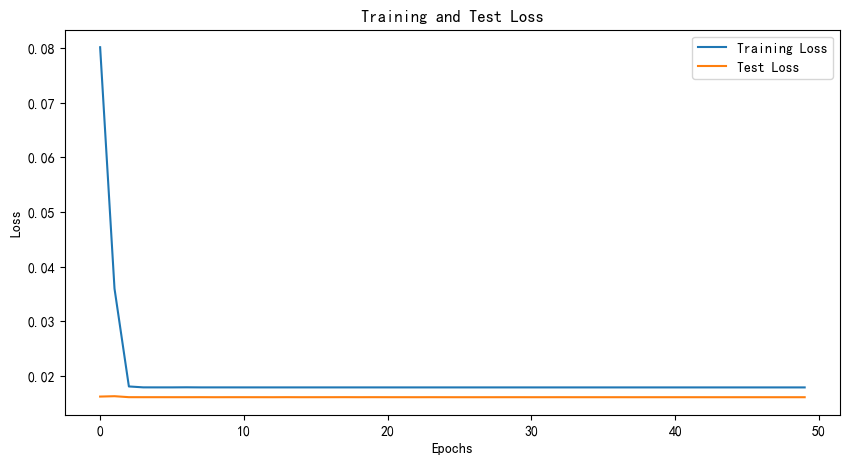

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [11]:
def predict_future(model, input_data):
    model.eval()
    with torch.no_grad():
        input_data = input_data.to(device)
        predicted_future, mu, logvar = model(input_data)  # 假设模型输出中包含预测结果及其分布参数
        return predicted_future, mu, logvar

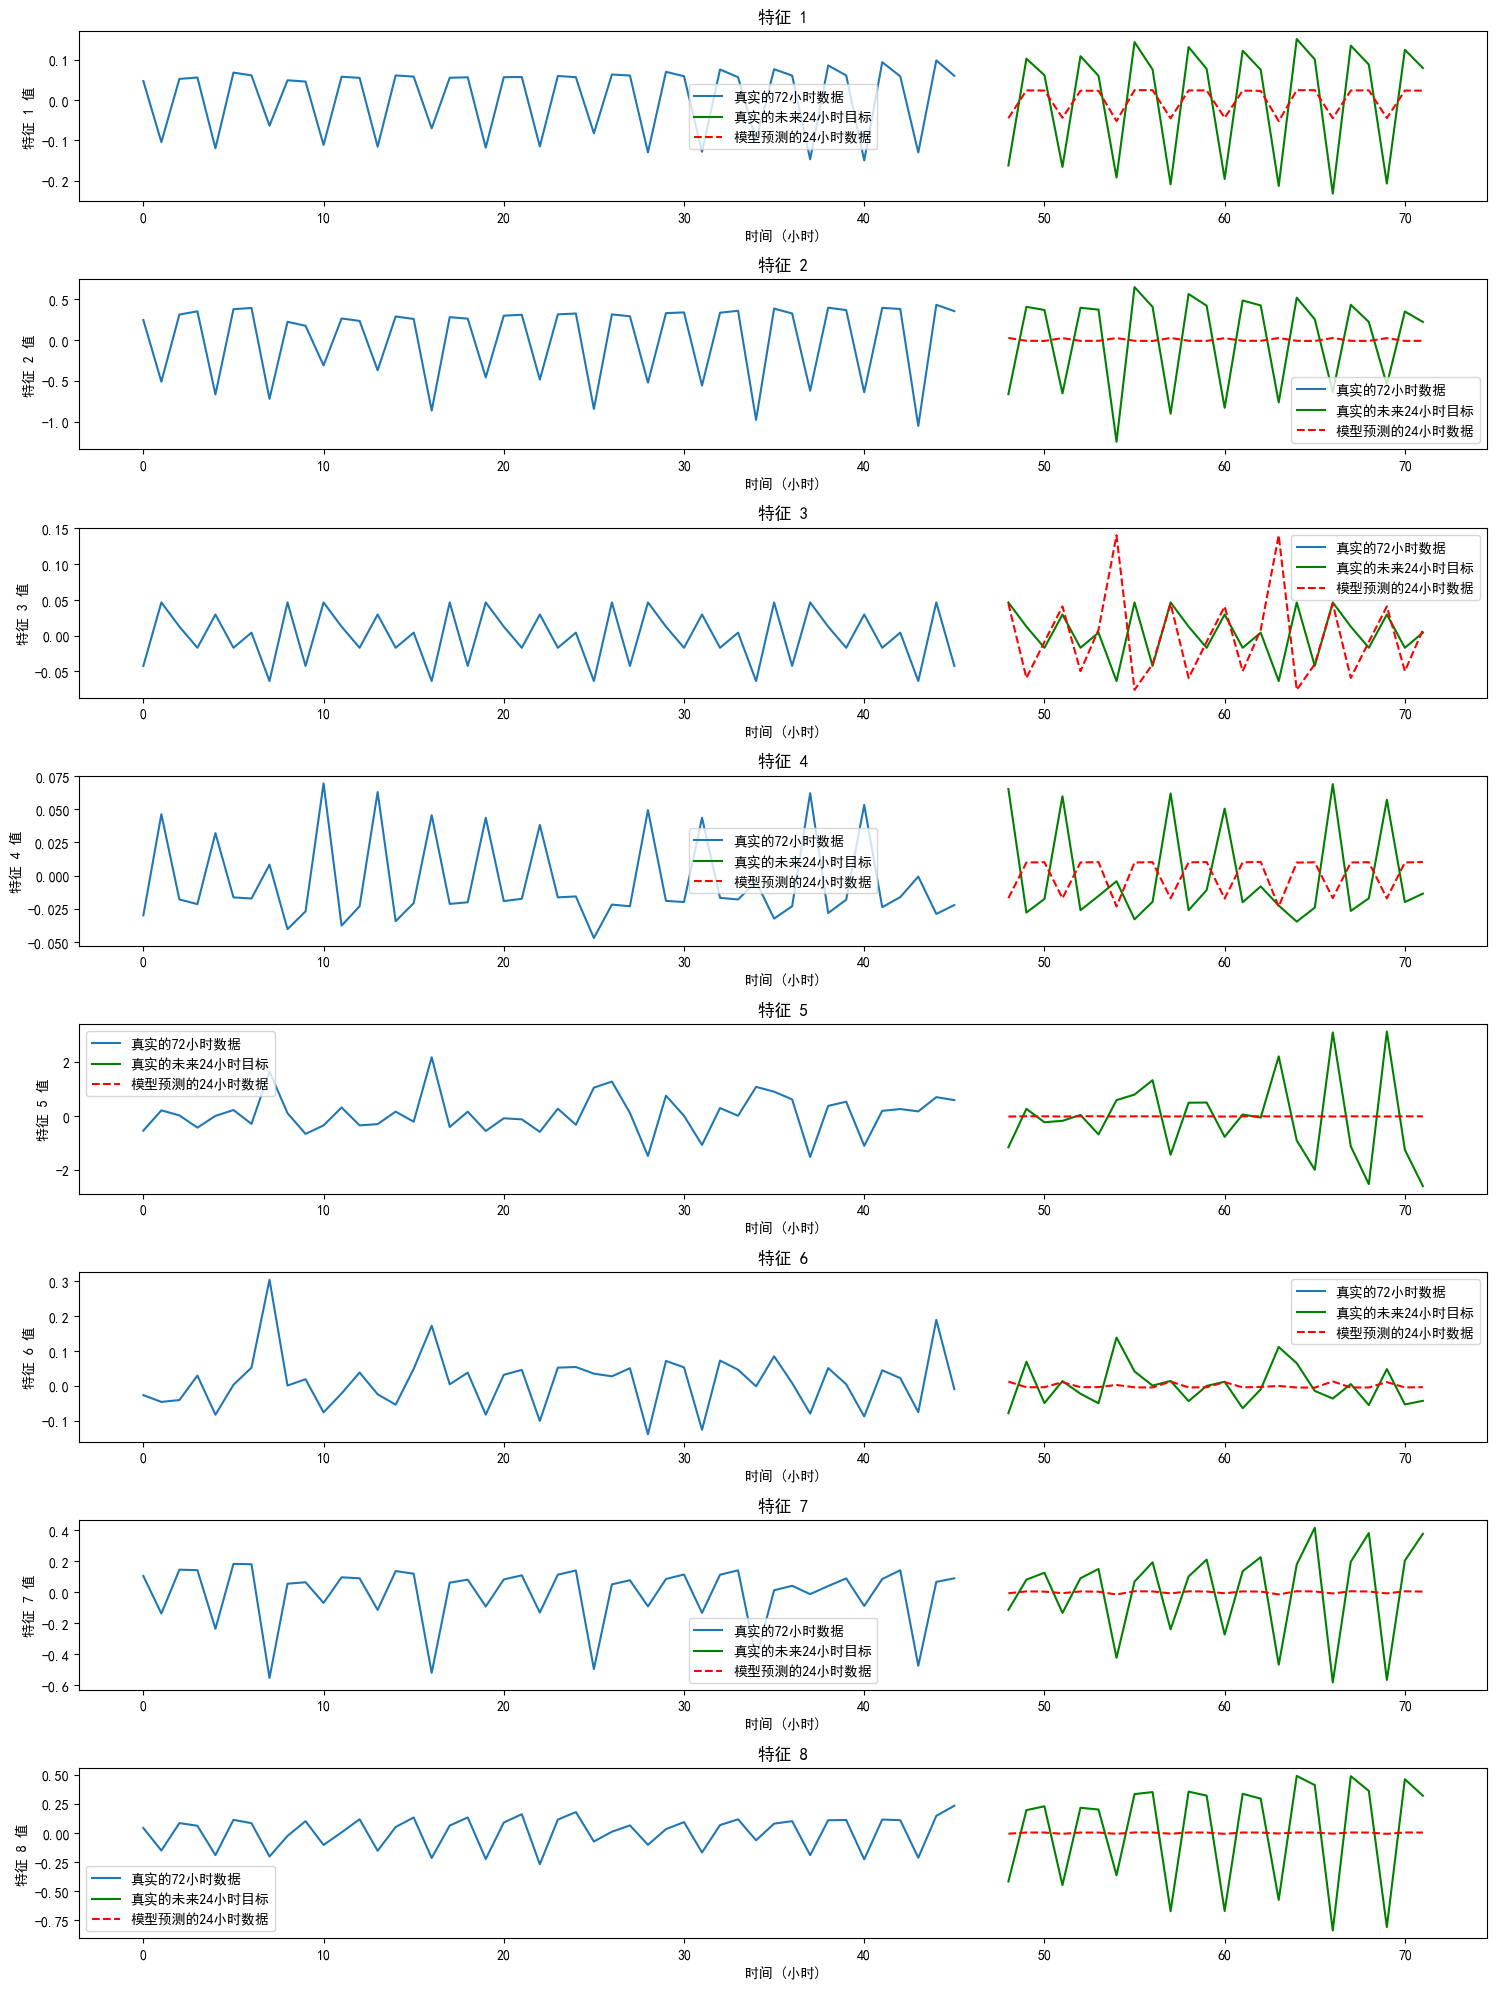

In [13]:
Num_Feature = 8
def evaluate_and_plot_features(model, test_loader):
    for batch in test_loader:
        inputs, targets = batch
        output,_,_ = predict_future(model, inputs)
        # 选择第一个样本
        single_input = inputs[0:1].view(1, -1).to(device)
        single_target = targets[0:1].to(device)
        output = output[0:1].to(device)
        break  # 只处理第一个batch
    # 将数据移回CPU以便打印或进一步处理
    single_input = single_input.cpu().view(-1, Num_Feature)  # 假设输入有9个特征
    single_target = single_target.cpu().view(-1, Num_Feature)
    output = output.cpu().view(-1, Num_Feature)

    # 绘制每个特征的图表
    num_features = Num_Feature
    plt.figure(figsize=(15, 20))
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(single_input[:, i], label='真实的72小时数据')
        plt.plot(range(48, 72), single_target[:, i], 'g', label='真实的未来24小时目标')
        plt.plot(range(48, 72), output[:, i], 'r--', label='模型预测的24小时数据')
        plt.title(f'特征 {i+1}')
        plt.xlabel('时间 (小时)')
        plt.ylabel(f'特征 {i+1} 值')
        plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数
evaluate_and_plot_features(model, test_loader)